In [155]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from time import time

register_matplotlib_converters()

In [8]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [185]:
catfish_sales = pd.read_csv('catfish.csv', parse_dates = [0], index_col=[0])

catfish_sales.head(-5)
a = catfish_sales[datetime(1986,1,1):datetime(1986,11,1)]
print(a)

            Total
Date             
1986-01-01   9034
1986-02-01   9596
1986-03-01  10558
1986-04-01   9002
1986-05-01   9239
1986-06-01   8951
1986-07-01   9668
1986-08-01  10188
1986-09-01   9896
1986-10-01  10649
1986-11-01   8917


In [175]:
catfish_sales.Date.head()
pd.infer_freq(catfish_sales.Date)
#catfish_sales = catfish_sales.asfreq()
#catfish_sales.head()

AttributeError: 'DataFrame' object has no attribute 'Date'

In [180]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

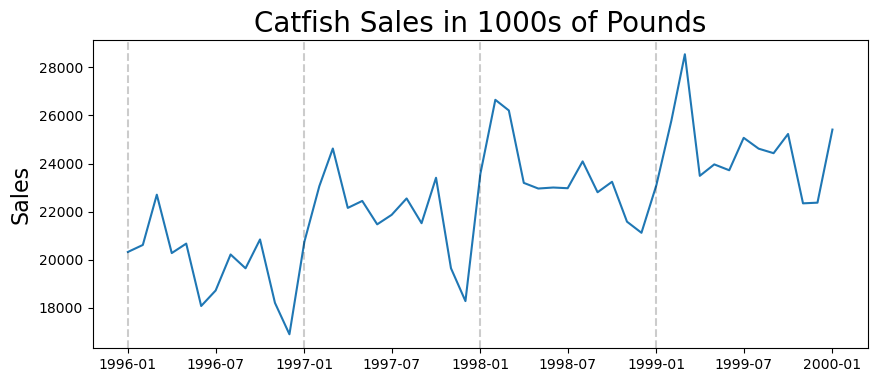

In [68]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

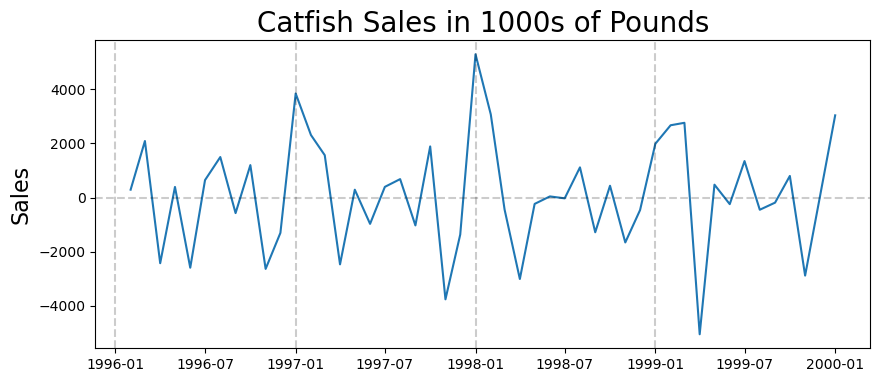

In [71]:
'''REMOVING THE TREND'''

first_diff = lim_catfish_sales.diff()[1:]

plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [156]:
#dickey fuller test
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

perform_adf_test(first_diff.Total)

ADF Statistic: -9.515039
p-value: 0.000000


[ 1.         -0.05546501 -0.27966346 -0.28953255 -0.09143885  0.26538778
 -0.01819253  0.23656204 -0.18606632 -0.32368194 -0.10034098  0.06289698
  0.58143123  0.02304198 -0.18324432 -0.28795919 -0.06250147]


<BarContainer object of 17 artists>

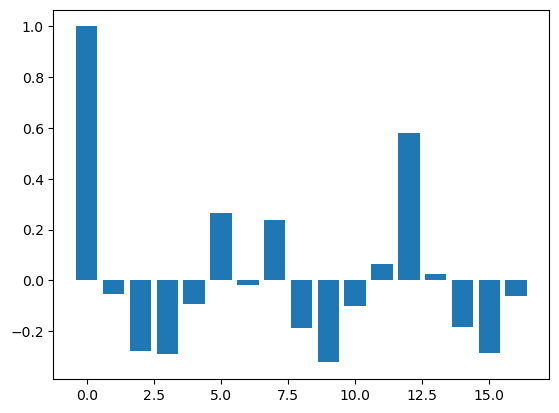

In [75]:
acf_vals = acf(first_diff)
print(acf_vals)
num_lags = 20
plt.bar(range(17), acf_vals[:num_lags])

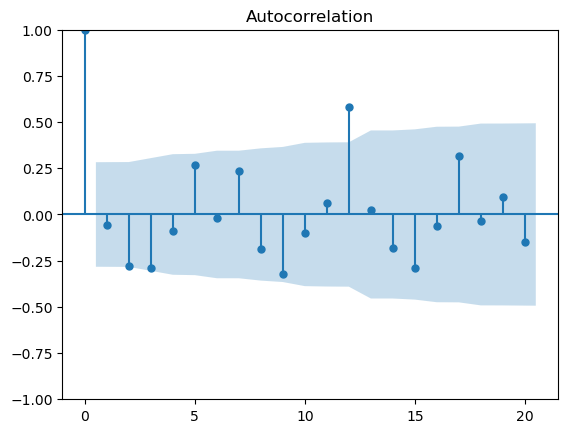

In [82]:
acf_plot = plot_acf(first_diff.Total, lags=20)

<BarContainer object of 17 artists>

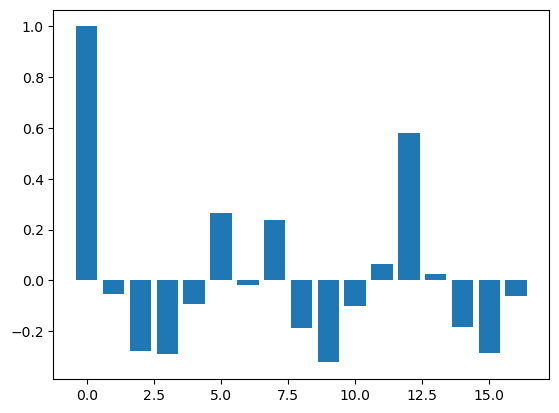

In [87]:
acf_vals = acf(first_diff)
#print(acf_vals)
num_lags = 20
plt.bar(range(17), acf_vals[:num_lags])

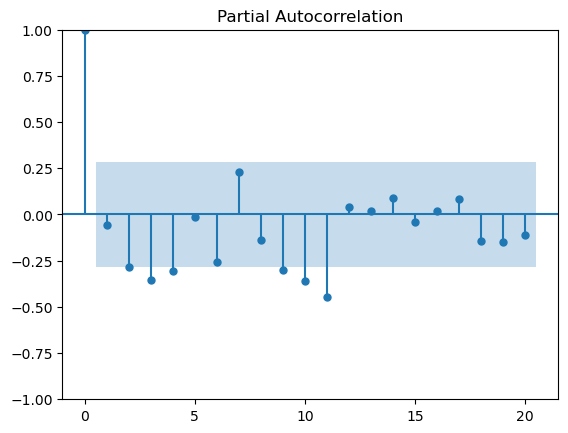

In [83]:
pacf_plot = plot_pacf(first_diff.Total, lags = 20)

In [160]:
#getting training and testing data

train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

In [161]:
#fitting sarima

my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model Fitting Time: 0.34391212463378906


In [163]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Thu, 04 Jan 2024   AIC                            737.269
Time:                                      14:57:27   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [164]:
#get predictions and residuals
predictions = model_fit.forecast(len(test_data))
print(predictions)
predictions = pd.Series(predictions, index=test_data.index)
print(predictions)
residuals = pd.Series(test_data.Total - predictions)
print(residuals)

1999-08-01    25695.475778
1999-09-01    25054.188758
1999-10-01    25642.858591
1999-11-01    24195.595942
1999-12-01    23677.344778
2000-01-01    26250.601923
Freq: MS, Name: predicted_mean, dtype: float64
Date
1999-08-01    25695.475778
1999-09-01    25054.188758
1999-10-01    25642.858591
1999-11-01    24195.595942
1999-12-01    23677.344778
2000-01-01    26250.601923
Name: predicted_mean, dtype: float64
Date
1999-08-01   -1077.475778
1999-09-01    -624.188758
1999-10-01    -413.858591
1999-11-01   -1851.595942
1999-12-01   -1305.344778
2000-01-01    -838.601923
dtype: float64


Text(0, 0.5, 'Error')

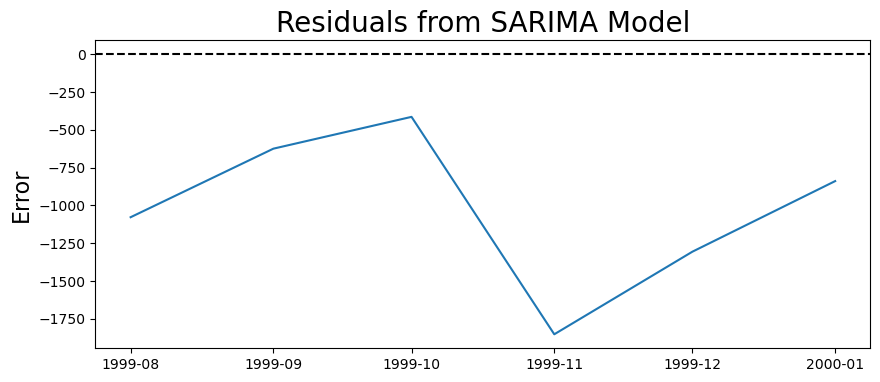

In [165]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

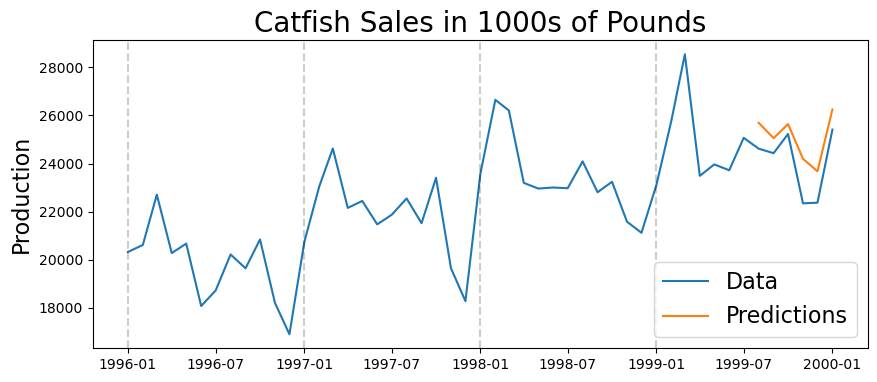

In [166]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [167]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.Total)),4))

Mean Absolute Percent Error: 0.0433


In [168]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3064272871507


In [145]:
#rolling forecast origin

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions.Total[train_end] = pred

print(rolling_predictions)

C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, s

                   Total
Date                    
1999-08-01  25436.565289
1999-09-01  24006.891580
1999-10-01  24787.125225
1999-11-01  23819.411799
1999-12-01  21798.391760
2000-01-01  25045.130300


C:\Users\gandh\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gandh\AppData\Local\Temp\ipykernel_22308\1138149674.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions.Total[train_end] = pred


In [147]:
rolling_residuals = test_data.Total - rolling_predictions.Total

Text(0, 0.5, 'Error')

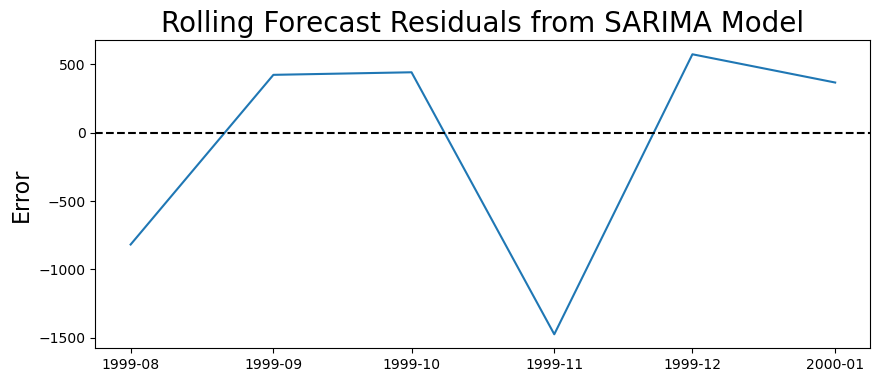

In [149]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

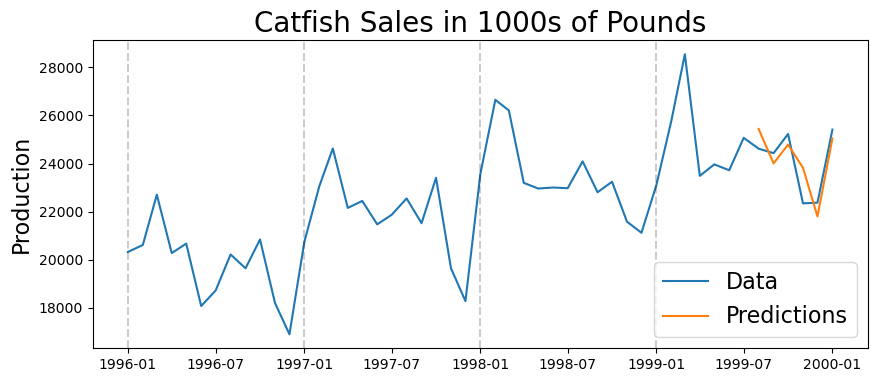

In [150]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [151]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 783.6647827815406


In [152]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data.Total)),4))

Mean Absolute Percent Error: 0.029


Each model has:
a log likelihood (
)
a number of parameters (
)
a number of samples used for fitting (
)
AIC = 2
 - 2
Lower AIC via higher log likelihood or less parameters
BIC = 
 - 2
Lower BIC via higher log likelihood or less parameters or less samples used in fitting

In [172]:
print(model_fit.aic)
print(model_fit.bic)

737.2693932237584
742.4824020786085
